# PrimeKG knowledge graph query and answer using embedding

Query a knowledge graph for drugs/diseases using embedding

**references:**


databases:
- PrimeKG knowledge graph: https://github.com/mims-harvard/PrimeKG
- STaRK question/answers: https://github.com/snap-stanford/stark
  - database explanation: https://stark.stanford.edu/dataset_prime.html

modules:
- embedding using Sentence Transformer: https://www.sbert.net/docs/quickstart.html
- project using these databases:
  - https://github.com/VirtualPatientEngine/AIAgents4Pharma
  - https://virtualpatientengine.github.io/AIAgents4Pharma/notebooks/talk2knowledgegraphs/tutorial_starkqa_primekg_textual_embeddings_nomic_embed_text/


## imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [ ]:
def random_mask(n,k):
    a = np.zeros(n, dtype=bool)
    a[:k] = 1
    np.random.shuffle(a)
    return a

## load dataset

In [5]:
primekg = pd.read_csv("kg.csv", low_memory=False)

In [6]:
primekg

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI
...,...,...,...,...,...,...,...,...,...,...,...,...
8100493,anatomy_protein_absent,expression absent,66747,4720,anatomy,cerebellar vermis,UBERON,5259,140,gene/protein,ADORA3,NCBI
8100494,anatomy_protein_absent,expression absent,63824,1377,anatomy,quadriceps femoris,UBERON,58254,105378952,gene/protein,KLF18,NCBI
8100495,anatomy_protein_absent,expression absent,63826,1379,anatomy,vastus lateralis,UBERON,58254,105378952,gene/protein,KLF18,NCBI
8100496,anatomy_protein_absent,expression absent,64523,2084,anatomy,heart left ventricle,UBERON,58254,105378952,gene/protein,KLF18,NCBI


## create nodes dataframe and edges index

In [117]:
nodes1 = primekg[["x_index", "x_name", "x_type"]].rename(columns={"x_index":"indx","x_name":"name","x_type":"type"})
nodes2 = primekg[["y_index", "y_name", "y_type"]].rename(columns={"y_index":"indx","y_name":"name","y_type":"type"})
nodes = pd.concat([nodes1,nodes2]).drop_duplicates().reset_index(drop=True)
nodes = nodes.sort_values(by="indx").reset_index(drop=True)
nodes

,indx,name,type
0,0,PHYHIP,gene/protein
1,1,GPANK1,gene/protein
2,2,ZRSR2,gene/protein
3,3,NRF1,gene/protein
4,4,PI4KA,gene/protein
...,...,...,...
129370,129370,Ion transport by P-type ATPases,pathway
129371,129371,Inhibition of voltage gated Ca2+ channels via...,pathway
129372,129372,anatomical entity,anatomy
129373,129373,multi-cellular organism,anatomy


In [118]:
if not np.all(nodes.index == nodes["indx"]):
    raise IOError("error")

In [ ]:
nodes.drop(columns="indx", inplace=True)

In [8]:
edges = primekg[["x_index","y_index"]].values
edges.shape

(8100498, 2)

In [9]:
len(nodes)/len(edges)

0.015971240286708297

## convert to text and transform to embedding

### enrichment (textual representation)

In [10]:
%%time
enriched_nodes = ["{} belongs to {} category.".format(n["name"],n["type"]) for i,n in tqdm(nodes.iterrows(), total=len(nodes))]

100%|█████████████████████████████████████████████████████| 129375/129375 [00:08<00:00, 14763.23it/s]

CPU times: user 8.73 s, sys: 87.9 ms, total: 8.82 s
Wall time: 8.86 s


In [11]:
# apply to dataframe
# nodes["text"] = enriched_nodes
# nodes

In [12]:
%%time
enriched_edges = ["{} ({}) is connected via {} to {} ({}).".format(e["x_name"],e["x_type"],e["display_relation"],e["y_name"],e["y_type"]) for i,e in tqdm(primekg.iterrows(), total=len(primekg))]

100%|███████████████████████████████████████████████████| 8100498/8100498 [09:57<00:00, 13556.82it/s]

CPU times: user 9min 55s, sys: 5.49 s, total: 10min
Wall time: 9min 58s


### embedding

#### transformer model

In [13]:
batch_size = 10 # for embedding

In [14]:
from sentence_transformers import SentenceTransformer

/home/pascal/python_virtual_environments/kg/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [15]:
model = SentenceTransformer("all-MiniLM-L6-v2")

#### apply embedding

##### nodes

In [ ]:
%%time
embeddings_nodes = []
#for i in tqdm(range(0,len(nodes),batch_size)):
#sentences = nodes.iloc[i:i+batch_size]["text"].values.tolist() # enriched_nodes
for i in tqdm(range(0,len(enriched_nodes),batch_size)):
    sentences = enriched_nodes[i:i+batch_size]
    embeddings_batch = model.encode(sentences)
    embeddings_nodes.extend(embeddings_batch)

len(embeddings_nodes)

In [ ]:
%%time
nodes["embedding"] = embeddings_nodes
nodes.to_parquet("embeddings_nodes.parquet")

In [25]:
embeddings_nodes = np.array(embeddings_nodes)
embeddings_nodes.shape

(129375, 384)

##### edges

In [ ]:
%%time
embeddings_edges = []
for i in tqdm(range(0,len(enriched_edges),batch_size)):
    sentences = enriched_edges[i:i+batch_size]
    embeddings_batch = model.encode(sentences)
    embeddings_edges.extend(embeddings_batch)

len(embeddings_edges)

In [ ]:
%%time
primekg["embedding"] = embeddings_edges
primekg.to_parquet("embeddings_edges.parquet")

In [ ]:
embeddings_edges = np.array(embeddings_edges)
embeddings_edges.shape

## query knowledge graph

### load data

The `stark_qa` database contains query and answer pairs. The `answer_ids` are nodes in the `primekg` graph.
Some queries have several possible answers (a list).

In [210]:
# load qa database
# stark_qa : (question,answer) pairs
starkqa_df = pd.read_csv("stark_qa.csv", converters={"answer_ids": lambda x: list(map(int,x.strip("[]").split(", ")))})
starkqa_df

,id,query,answer_ids
0,10328,"Which medications, designed to target genes or...",[18423]
1,11172,Identify pathways associated with the activati...,[62404]
2,2260,I'm looking for tablet or capsule medications ...,[18967]
3,2304,Can you identify genes and proteins associated...,[1636]
4,11016,Which medication acts by engaging with genes o...,"[16589, 16590, 16591, 16592, 14801, 16595, 14717]"
...,...,...,...
11199,8752,Find health conditions linked to diacylglycero...,[33575]
11200,9974,What are the observed effects or phenotypes as...,"[94246, 33738, 94374, 93734]"
11201,8636,What are the observed effects or phenotypes as...,"[23000, 23091, 25269]"
11202,9810,Identify genes or proteins that interact with ...,"[5720, 4550]"


### Method 1: linear decomposition of query in QA pairs and interpolate the answer

- Get the embedding of all queries from the `stark_qa` database. Matrix: `embeddings_queries`.
- For a custom query, project its embedding on `embeddings_queries`. The coefficients: `query_decomposed`.
- Get the mean embedding for each `answer_ids` as nodes in the KG.
- Interpolate the answer's embedding using the query decomposed coefficients.
- Now that we have the answer's embedding, find the closest known answer in the nodes.

#### embed queries

In [435]:
%%time
embeddings_queries = []
for i in tqdm(range(0,len(starkqa_df),batch_size)):
    sentences = starkqa_df.iloc[i:i+batch_size]["query"].values.tolist()
    embeddings_batch = model.encode(sentences)
    embeddings_queries.extend(embeddings_batch)

len(embeddings_queries)

100%|████████████████████████████████████████████████████████████| 1121/1121 [00:24<00:00, 45.93it/s]

CPU times: user 31.1 s, sys: 2.64 s, total: 33.7 s
Wall time: 24.4 s


11204

In [436]:
embeddings_queries = np.array(embeddings_queries)
embeddings_queries.shape

(11204, 384)

#### embed answers

In [437]:
answer_ids_list = list(starkqa_df["answer_ids"].values)
len(answer_ids_list)

11204

In [438]:
# answers are nodes in primekg, get their embedding (in case there are several answers, get the mean)
embedding_answers = np.array([np.mean(embeddings_nodes[answer_ids], axis=0) for answer_ids in answer_ids_list])
embedding_answers.shape

(11204, 384)

#### decompose query

In [439]:
%%time
embeddings_queries_inv = np.linalg.pinv(embeddings_queries.T)
embeddings_queries_inv.shape

CPU times: user 10.6 s, sys: 5.66 s, total: 16.3 s
Wall time: 1.15 s


(11204, 384)

In [440]:
# any query
query = "disease that affects heart and lung"
print("Query: {}".format(query))

Query: disease that affects heart and lung


In [441]:
# embed user query
emb_query = model.encode(query)
emb_query.shape

(384,)

In [442]:
query_decomposed = np.dot(embeddings_queries_inv, emb_query)
query_decomposed.shape

(11204,)

In [443]:
# starkqa_df.iloc[np.argmax(query_decomposed)].values

#### interpolate the answer embedding

In [444]:
# linear combination: coefficients from query decomposition
##query_answer = np.sum(query_decomposed * embedding_answers.T, axis=1)
query_answer = np.dot(query_decomposed, embedding_answers)
query_answer.shape

(384,)

#### finding the answer (by embedding comparision to find most similar node)

In [445]:
# Calculate cosine distances
#~ from scipy.spatial.distance import cosine
#~ distances = [cosine(query_answer, embeddings_node) for embeddings_node in embeddings_nodes]

# euclidean distance
distances = np.linalg.norm(query_answer - embeddings_nodes, axis=1)
distances

array([0.9819188 , 1.0261418 , 1.051791  , ..., 0.9777353 , 0.98827606,
       1.0451933 ], dtype=float32)

In [446]:
topk = 10

In [449]:
print("Query: {}".format(query))

#nodes.iloc[np.argsort(distances)[:topk]]

nodes_ = nodes.copy()
nodes_["distance"] = distances
nodes_.sort_values(by="distance").iloc[:topk]

Query: disease that affects heart and lung


,name,type,distance
35833,lung disease,disease,0.680520
35669,heart disease,disease,0.686365
37522,myocardial disorder,disease,0.696601
36441,pulmonary valve disease,disease,0.708517
35761,cardiovascular disease,disease,0.711896
36235,chronic pulmonary heart disease,disease,0.711911
98239,pulmonary hypertension owing to lung disease a...,disease,0.716086
36836,interstitial lung disease,disease,0.717850
38437,pulmonary hypertension,disease,0.718808
28308,"heart, malformation of",disease,0.721493


#### interactive

In [ ]:
query = input("Query:") # your custom query
emb_query = model.encode(query) # embed user query
query_decomposed = np.dot(embeddings_queries_inv, emb_query) # decompose embedding of user query
query_answer = np.dot(query_decomposed, embedding_answers) # interpolate the answer embedding
distances = np.linalg.norm(query_answer - embeddings_nodes, axis=1)
# print answers
#nodes.iloc[np.argsort(distances)[:topk]] 

nodes_ = nodes.copy()
nodes_["distance"] = distances
nodes_.sort_values(by="distance").iloc[:topk]

#### Benchmark

In [418]:
train_ratio = 0.75

In [419]:
data_len = len(starkqa_df)
train_len = int(data_len*train_ratio)
train_len, data_len

(8403, 11204)

In [420]:
mask_train = random_mask(data_len,train_len)
mask_test = ~mask_train
sum(mask_test)

2801

In [421]:
txt1 = "StarkQA dataset: {} QA pairs, train ratio: {:.2f}, train/test size: {}/{}".format(data_len, train_ratio, sum(mask_train), sum(mask_test))
txt2 = "PrimeKG nodes: {}".format(len(primekg))
header_txt = "{}\n{}".format(txt2,txt1)
print(header_txt)

PrimeKG nodes: 8100498
StarkQA dataset: 11204 QA pairs, train ratio: 0.75, train/test size: 8403/2801


In [422]:
# reduce full data to training data
embeddings_queries_train = embeddings_queries[mask_train]
embedding_answers_train = embedding_answers[mask_train]
embeddings_queries_train_inv = np.linalg.pinv(embeddings_queries_train.T)

embeddings_queries_train.shape, embedding_answers_train.shape, embeddings_queries_train_inv.shape

((8403, 384), (8403, 384), (8403, 384))

In [423]:
# use other data as test data

In [424]:
embeddings_queries_test = embeddings_queries[mask_test] # these queries were not seen before
embeddings_queries_test.shape

(2801, 384)

In [425]:
# project test queries on training queries
query_decomposed = np.dot(embeddings_queries_train_inv, embeddings_queries_test.T).T
query_decomposed.shape # every query from test set has answer weights from nodes from train set

(2801, 8403)

In [426]:
# linear combination: coefficients from query decomposition
query_answer = np.dot(query_decomposed, embedding_answers_train)
query_answer.shape # every answer from test query has its embedding

(2801, 384)

In [427]:
# and every node has its embedding, since the nodes are possible answers, compare them with the query answer embedding
embeddings_nodes.shape

(129375, 384)

In [428]:
distances = np.array([np.linalg.norm(query_answer_ - embeddings_nodes, axis=1) for query_answer_ in tqdm(query_answer)])
distances.shape

100%|████████████████████████████████████████████████████████████| 2801/2801 [09:06<00:00,  5.13it/s]


(2801, 129375)

In [429]:
answer_ids_list_test = list(np.array(answer_ids_list,dtype=object)[mask_test]) # true answers from test set
len(answer_ids_list_test)

2801

In [430]:
# find where the answer was found at which position in rank distances

In [431]:
order_ratio_mean_list = []

for dist,aids in tqdm(zip(distances,answer_ids_list_test)):
    #print(dist,aids)
    dist_indxsort = np.argsort(dist)
    order_ratio_list = []
    for aid in aids:
        #print(aid)
        order_found = np.argwhere(dist_indxsort==aid)[0][0]
        order_ratio = order_found / len(dist_indxsort) # quantile order
        order_ratio_list.append(order_ratio)
    order_ratio_mean = np.mean(order_ratio_list)
    order_ratio_mean_list.append(order_ratio_mean)

2801it [00:27, 103.53it/s]


In [432]:
o_mean, o_median = np.mean(order_ratio_mean_list), np.median(order_ratio_mean_list)
print("mean: {:.3f}".format(o_mean))
print("median: {:.3f}".format(o_median))

mean: 0.045
median: 0.017


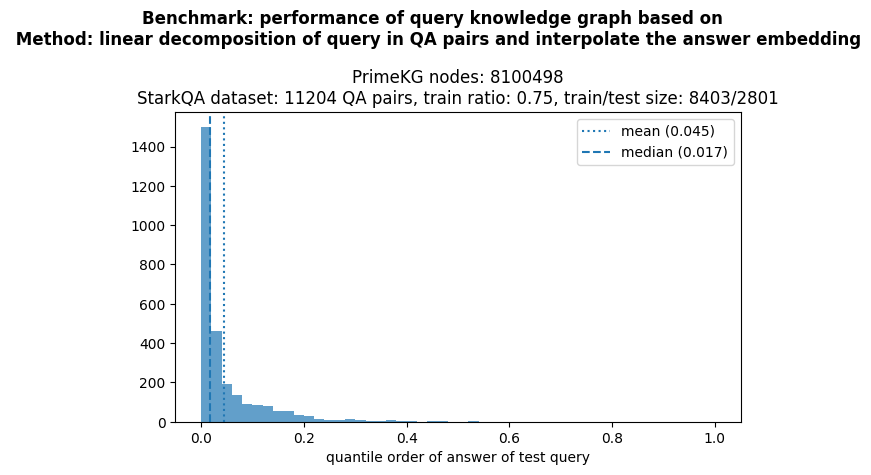

In [433]:
plt.hist(order_ratio_mean_list, range=(0,1), bins=50, alpha=.7)
plt.axvline(x=o_mean, label="mean ({:.3f})".format(o_mean), ls='dotted')
plt.axvline(x=o_median, label="median ({:.3f})".format(o_median), ls='dashed')
plt.xlabel("quantile order of answer of test query")
plt.suptitle("Benchmark: performance of query knowledge graph based on \n Method: linear decomposition of query in QA pairs and interpolate the answer embedding", fontweight="bold")
plt.title(header_txt)
plt.legend()
plt.tight_layout()
plt.show()

## Graph

In [ ]:
primekg.groupby(by=["x_type","y_type"])["relation"].value_counts()

In [ ]:
import networkx as nx

In [ ]:
G = nx.from_pandas_edgelist(df=primekg, source='x_index', target='y_index', edge_attr='relation', create_using=nx.DiGraph)

In [ ]:
len(G.nodes)

In [ ]:
len(G.edges)

In [434]:
# TODO: use graph to find target node, including similarity of query to nodes and edges